# Classification Methods Comparison: Can Different Methods Better Utilize Synthetic Data?

This notebook investigates whether different classification methods and feature extraction techniques can better leverage LLM-generated synthetic tweets for fake news detection, compared to traditional oversampling.

## Background:
- **Original dataset**: ~133k tweets (68k real, 65k fake)
- **Synthetic data**: 3772 LLM-generated fake tweets (modified facts from real tweets)
- **Known issue**: Synthetic tweets are more similar to real than fake tweets, causing performance degradation
- **Hypothesis**: Different classification methods or features might better distinguish synthetic fakes from reals

## Analysis Overview:
1. **Baseline**: Original data only
2. **Traditional Oversampling**: SMOTE/Random oversampling of minority class
3. **Synthetic Data Integration**: Various ways to incorporate synthetic tweets
4. **Feature Methods**: TF-IDF, Count, Emotion-based, Combined features
5. **Models**: Logistic Regression, Random Forest, BERT, RoBERTa
6. **Goal**: Find methods that can effectively use synthetic data vs just oversampling

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
import re
from collections import Counter
import time

warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Oversampling imports
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBALANCED_LEARN_AVAILABLE = True
except ImportError:
    print("⚠️ Installing imbalanced-learn for SMOTE...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBALANCED_LEARN_AVAILABLE = True

# Deep learning imports
try:
    import torch
    from transformers import (
        AutoTokenizer, AutoModelForSequenceClassification,
        TrainingArguments, Trainer, pipeline
    )
    from datasets import Dataset
    TRANSFORMERS_AVAILABLE = True
    print(f"✅ Transformers available with PyTorch {torch.__version__}")
    if torch.cuda.is_available():
        print(f"✅ CUDA available: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠️ CUDA not available, using CPU")
except ImportError:
    print("⚠️ Transformers library not available. BERT/RoBERTa models will be skipped.")
    TRANSFORMERS_AVAILABLE = False

# Emotion analysis
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
    print("✅ TextBlob available for enhanced emotion features")
except ImportError:
    print("⚠️ TextBlob not available. Emotion features will be basic.")
    TEXTBLOB_AVAILABLE = False

plt.style.use('default')
sns.set_palette("husl")

print("📊 Classification Methods Comparison: Synthetic Data vs Oversampling")
print(f"   Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Transformers available: {TRANSFORMERS_AVAILABLE}")
print(f"   TextBlob available: {TEXTBLOB_AVAILABLE}")
print(f"   SMOTE available: {IMBALANCED_LEARN_AVAILABLE}")

if TRANSFORMERS_AVAILABLE and torch.cuda.is_available():
    print("🚀 GPU acceleration enabled for transformer models!")

✅ Transformers available with PyTorch 2.7.1+cu126
✅ CUDA available: NVIDIA GeForce GTX 1060 6GB
✅ TextBlob available for enhanced emotion features
📊 Classification Methods Comparison: Synthetic Data vs Oversampling
   Started at: 2025-08-17 23:55:49
   Transformers available: True
   TextBlob available: True
   SMOTE available: True
🚀 GPU acceleration enabled for transformer models!


## 1. Data Loading and Preparation

In [8]:
# Load original dataset
df_original = pd.read_csv('data/raw/Twitter_Analysis.csv')

print(f"📈 Original dataset loaded")
print(f"   Shape: {df_original.shape}")
print(f"   Columns: {df_original.columns.tolist()}")

# Check the target variable encoding
print(f"\n🎯 Target variable distribution:")
target_counts = df_original['majority_target'].value_counts().sort_index()
print(target_counts)

# Determine which class is real vs fake based on actual data
real_count = target_counts.get(True, 0)  # True = real tweets
fake_count = target_counts.get(False, 0)  # False = fake tweets

print(f"\n📊 Data composition:")
print(f"   Real tweets (majority_target=True): {real_count:,} ({real_count/len(df_original)*100:.1f}%)")
print(f"   Fake tweets (majority_target=False): {fake_count:,} ({fake_count/len(df_original)*100:.1f}%)")
print(f"   Total: {len(df_original):,} tweets")
print(f"   Imbalance ratio: {real_count/fake_count:.2f}:1 (real:fake)")

# Convert boolean target to numeric (True=1, False=0)
df_original['numeric_target'] = df_original['majority_target'].astype(int)
print(f"\n🔄 Converted target: True->1 (real), False->0 (fake)")

# Show sample tweets by class
print(f"\n📝 Sample real tweets (majority_target=True):")
real_tweets = df_original[df_original['majority_target'] == True]['tweet'].head(3)
for i, tweet in enumerate(real_tweets, 1):
    print(f"   {i}. {tweet[:100]}...")

print(f"\n📝 Sample fake tweets (majority_target=False):")
fake_tweets = df_original[df_original['majority_target'] == False]['tweet'].head(3)
for i, tweet in enumerate(fake_tweets, 1):
    print(f"   {i}. {tweet[:100]}...")

📈 Original dataset loaded
   Shape: (134198, 64)
   Columns: ['Unnamed: 0', 'majority_target', 'statement', 'BinaryNumTarget', 'tweet', 'followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'listed_count', 'following', 'embeddings', 'BotScore', 'BotScoreBinary', 'cred', 'normalize_influence', 'mentions', 'quotes', 'replies', 'retweets', 'favourites', 'hashtags', 'URLs', 'unique_count', 'total_count', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage', 'PERSON_percentage', 'MONEY_percentage', 'DATE_percentage', 'CARDINAL_percentage', 'PERCENT_percentage', 'ORDINAL_percentage', 'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage', 'EVENT_percentage', 'TIME_percentage', 'LOC_percentage', 'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage', 'Word count', 'Max word length', 'Min word length', 'Average word length', 'present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunctions', 'dots', 'ex

In [10]:
# Load synthetic dataset
synthetic_data_list = []

try:
    with open('results/large_scale_batch_20250812.json', 'r') as f:
        llm_batch_results = json.load(f)
    
    if 'results' in llm_batch_results:
        for result_item in llm_batch_results['results']:
            if isinstance(result_item, dict) and 'generated_text' in result_item:
                synthetic_data_list.append(result_item['generated_text'])
    
    print(f"🤖 Synthetic dataset loaded")
    print(f"   Total synthetic tweets: {len(synthetic_data_list):,}")
    print(f"   Expected: ~3,772 LLM-generated fake tweets")
    
    if len(synthetic_data_list) > 0:
        print(f"\n📝 Sample synthetic tweets:")
        for i, tweet in enumerate(synthetic_data_list[:3], 1):
            print(f"   {i}. {tweet[:100]}...")
        
        print(f"\n📊 Synthetic data context:")
        print(f"   → These are LLM-generated FAKE tweets (should be labeled as 0)")
        print(f"   → Generated by modifying facts in real tweets")
        print(f"   → Known issue: More similar to real tweets than original fake tweets")
        print(f"   → Goal: Test if different methods can better distinguish them")
        
except Exception as e:
    print(f"⚠️ Warning: Could not load synthetic tweets ({e})")
    print(f"   This experiment will compare different methods on original data only")
    synthetic_data_list = []

🤖 Synthetic dataset loaded
   Total synthetic tweets: 3,772
   Expected: ~3,772 LLM-generated fake tweets

📝 Sample synthetic tweets:
   1. @GOP The ABC and by default the FictionalGroup released 5000 Taliban fighters and the new leader of ...
   2. @MalcolmNance Come to really think of it, the Putin Administration were fucking idiots. They make a ...
   3. @Chaser41003 @JosephGusek @kayleighmcenany So why did Barack Obama let 10000 Al-Qaeda fighters out o...

📊 Synthetic data context:
   → These are LLM-generated FAKE tweets (should be labeled as 0)
   → Generated by modifying facts in real tweets
   → Known issue: More similar to real tweets than original fake tweets
   → Goal: Test if different methods can better distinguish them


## 2. Feature Extraction Methods

In [11]:
class FeatureExtractor:
    """Comprehensive feature extraction for text classification"""
    
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
        self.count_vectorizer = CountVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
        self.fitted = False
    
    def extract_basic_features(self, texts):
        """Extract basic text features like length, word count, etc."""
        features = []
        
        for text in texts:
            text_str = str(text)
            
            # Basic length features
            char_count = len(text_str)
            word_count = len(text_str.split())
            avg_word_length = np.mean([len(word) for word in text_str.split()]) if word_count > 0 else 0
            
            # Special character counts
            hashtag_count = text_str.count('#')
            mention_count = text_str.count('@')
            url_count = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text_str))
            exclamation_count = text_str.count('!')
            question_count = text_str.count('?')
            
            # Case features
            upper_ratio = sum(1 for c in text_str if c.isupper()) / len(text_str) if len(text_str) > 0 else 0
            
            features.append([
                char_count, word_count, avg_word_length,
                hashtag_count, mention_count, url_count,
                exclamation_count, question_count, upper_ratio
            ])
        
        return np.array(features)
    
    def extract_emotion_features(self, texts):
        """Extract emotion-based features"""
        features = []
        
        # Emotion keywords
        positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love', 'like', 'happy', 'joy']
        negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'dislike', 'sad', 'angry', 'frustrated', 'disappointed']
        urgency_words = ['urgent', 'immediately', 'asap', 'quickly', 'fast', 'hurry', 'rush', 'emergency']
        
        for text in texts:
            text_str = str(text).lower()
            words = text_str.split()
            
            # Count emotion words
            positive_count = sum(1 for word in words if word in positive_words)
            negative_count = sum(1 for word in words if word in negative_words)
            urgency_count = sum(1 for word in words if word in urgency_words)
            
            # Sentiment polarity (if TextBlob available)
            if TEXTBLOB_AVAILABLE:
                try:
                    blob = TextBlob(text_str)
                    polarity = blob.sentiment.polarity
                    subjectivity = blob.sentiment.subjectivity
                except:
                    polarity = 0
                    subjectivity = 0
            else:
                polarity = (positive_count - negative_count) / len(words) if len(words) > 0 else 0
                subjectivity = (positive_count + negative_count) / len(words) if len(words) > 0 else 0
            
            features.append([
                positive_count, negative_count, urgency_count,
                polarity, subjectivity
            ])
        
        return np.array(features)
    
    def extract_tfidf_features(self, texts, fit=False):
        """Extract TF-IDF features"""
        if fit or not self.fitted:
            return self.tfidf_vectorizer.fit_transform(texts)
        else:
            return self.tfidf_vectorizer.transform(texts)
    
    def extract_count_features(self, texts, fit=False):
        """Extract count vectorization features"""
        if fit or not self.fitted:
            return self.count_vectorizer.fit_transform(texts)
        else:
            return self.count_vectorizer.transform(texts)
    
    def extract_combined_features(self, texts, fit=False):
        """Extract and combine all feature types"""
        from scipy import sparse
        
        # Extract all feature types
        basic_features = self.extract_basic_features(texts)
        emotion_features = self.extract_emotion_features(texts)
        tfidf_features = self.extract_tfidf_features(texts, fit=fit)
        
        # Combine features
        dense_features = np.hstack([basic_features, emotion_features])
        combined_features = sparse.hstack([sparse.csr_matrix(dense_features), tfidf_features])
        
        if fit:
            self.fitted = True
        
        return combined_features

print("🔧 Feature extraction classes ready")

🔧 Feature extraction classes ready


## 3. Classification Models

In [12]:
class ClassificationModels:
    """Collection of classification models for comparison"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def get_traditional_models(self):
        """Get traditional ML models"""
        return {
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        }
    
    def train_traditional_model(self, model, X_train, y_train, X_test, y_test, model_name):
        """Train and evaluate a traditional ML model"""
        start_time = time.time()
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'f1_minority': f1_score(y_test, y_pred, pos_label=0),
            'training_time': time.time() - start_time
        }
        
        if y_pred_proba is not None:
            metrics['auc'] = roc_auc_score(y_test, y_pred_proba)
        
        return metrics, y_pred, y_pred_proba
    
    def get_transformer_pipeline(self, model_name='distilbert-base-uncased'):
        """Get a transformer-based classification pipeline"""
        if not TRANSFORMERS_AVAILABLE:
            return None
        
        try:
            # Use a pre-trained sentiment analysis pipeline
            classifier = pipeline(
                "sentiment-analysis", 
                model=model_name,
                return_all_scores=True
            )
            return classifier
        except Exception as e:
            print(f"⚠️ Could not load {model_name}: {e}")
            return None
    
    def evaluate_transformer_model(self, model, texts, y_true, model_name):
        """Evaluate transformer model"""
        if model is None:
            return None, None, None
        
        start_time = time.time()
        
        try:
            # Get predictions
            predictions = model(texts[:100])  # Limit for speed
            
            # Convert to binary predictions (assuming positive sentiment = 1)
            y_pred = []
            y_pred_proba = []
            
            for pred in predictions:
                if isinstance(pred, list):
                    # Find positive/negative scores
                    pos_score = next((p['score'] for p in pred if 'POSITIVE' in p['label'].upper()), 0.5)
                    y_pred_proba.append(pos_score)
                    y_pred.append(1 if pos_score > 0.5 else 0)
                else:
                    # Single prediction
                    score = pred['score'] if 'POSITIVE' in pred['label'].upper() else 1 - pred['score']
                    y_pred_proba.append(score)
                    y_pred.append(1 if score > 0.5 else 0)
            
            y_test_subset = y_true[:len(y_pred)]
            
            # Metrics
            metrics = {
                'accuracy': accuracy_score(y_test_subset, y_pred),
                'precision': precision_score(y_test_subset, y_pred, average='weighted'),
                'recall': recall_score(y_test_subset, y_pred, average='weighted'),
                'f1': f1_score(y_test_subset, y_pred, average='weighted'),
                'f1_minority': f1_score(y_test_subset, y_pred, pos_label=0),
                'auc': roc_auc_score(y_test_subset, y_pred_proba),
                'training_time': time.time() - start_time,
                'sample_size': len(y_pred)
            }
            
            return metrics, y_pred, y_pred_proba
            
        except Exception as e:
            print(f"⚠️ Error evaluating {model_name}: {e}")
            return None, None, None

print("🤖 Classification model classes ready")

🤖 Classification model classes ready


## 4. Experiment Setup and Execution

In [15]:
def prepare_datasets():
    """Prepare datasets for comprehensive comparison"""
    datasets = {}
    
    # Calculate the original imbalance (3,772 difference)
    original_texts = df_original['tweet'].tolist()
    original_labels = df_original['numeric_target'].tolist()
    
    real_count = sum(original_labels)  # real tweets (1)
    fake_count = len(original_labels) - sum(original_labels)  # fake tweets (0)
    original_imbalance = real_count - fake_count  # Should be ~3,772
    
    print(f"📊 Full dataset class distribution:")
    print(f"   Real tweets (1): {real_count:,}")
    print(f"   Fake tweets (0): {fake_count:,}")
    print(f"   Imbalance: +{original_imbalance:,} more real tweets")
    print(f"   This is why you generated {len(synthetic_data_list):,} synthetic fake tweets!")
    
    # 1. BASELINE: Original data only (imbalanced) - then split
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        original_texts, original_labels, test_size=0.2, random_state=42, stratify=original_labels
    )
    
    datasets['baseline'] = {
        'X_train': X_train_base,
        'y_train': y_train_base,
        'X_test': X_test_base,
        'y_test': y_test_base,
        'name': 'Baseline (Imbalanced Original)',
        'description': f'Original imbalanced data (+{original_imbalance:,} real tweets)'
    }
    
    # 2. RANDOM OVERSAMPLING: Balance full dataset, then split
    print(f"\\n🔄 Applying random oversampling to full dataset...")
    
    # Create balanced dataset by oversampling minority class (fake tweets)
    full_df = pd.DataFrame({'text': original_texts, 'label': original_labels})
    minority_samples = full_df[full_df['label'] == 0]  # fake tweets
    
    # Random oversample to match majority class
    oversampled_minority = minority_samples.sample(n=original_imbalance, replace=True, random_state=42)
    balanced_full_random = pd.concat([full_df, oversampled_minority]).sample(frac=1, random_state=42)
    
    print(f"   Before: {len(full_df):,} samples (R:{real_count:,}, F:{fake_count:,})")
    new_fake_count = fake_count + original_imbalance
    print(f"   After: {len(balanced_full_random):,} samples (R:{real_count:,}, F:{new_fake_count:,})")
    
    # Now split the balanced dataset
    X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
        balanced_full_random['text'].tolist(), 
        balanced_full_random['label'].tolist(), 
        test_size=0.2, random_state=42, stratify=balanced_full_random['label'].tolist()
    )
    
    datasets['random_oversample'] = {
        'X_train': X_train_random,
        'y_train': y_train_random,
        'X_test': X_test_random,
        'y_test': y_test_random,
        'name': 'Random Oversampling',
        'description': f'Random oversampling: +{original_imbalance:,} duplicated fake tweets'
    }
    
    # 3. SYNTHETIC DATA APPROACH: Add synthetic tweets to full dataset, then split
    if len(synthetic_data_list) > 0:
        print(f"\\n🤖 Applying synthetic data balancing to full dataset...")
        print(f"   Available synthetic tweets: {len(synthetic_data_list):,}")
        print(f"   Original imbalance to fill: {original_imbalance:,}")
        
        # Use synthetic tweets to balance the dataset
        synthetic_to_use = min(len(synthetic_data_list), original_imbalance)
        
        # Add synthetic tweets as fake samples (label=0) to the full dataset
        synthetic_full_texts = original_texts + synthetic_data_list[:synthetic_to_use]
        synthetic_full_labels = original_labels + [0] * synthetic_to_use
        
        print(f"   Before: {len(original_texts):,} samples (R:{real_count:,}, F:{fake_count:,})")
        new_synthetic_fake_count = fake_count + synthetic_to_use
        print(f"   After: {len(synthetic_full_texts):,} samples (R:{real_count:,}, F:{new_synthetic_fake_count:,})")
        
        # Split the synthetic-balanced dataset
        X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
            synthetic_full_texts, synthetic_full_labels, 
            test_size=0.2, random_state=42, stratify=synthetic_full_labels
        )
        
        datasets['synthetic_balance'] = {
            'X_train': X_train_synth,
            'y_train': y_train_synth,
            'X_test': X_test_synth,
            'y_test': y_test_synth,
            'name': 'Synthetic Data Balancing',
            'description': f'LLM-generated synthetic: +{synthetic_to_use:,} synthetic fake tweets'
        }
        
        # 4. HYBRID APPROACH: If we have different amounts of synthetic data
        if len(synthetic_data_list) < original_imbalance:
            print(f"\\n🔄 Creating hybrid approach (insufficient synthetic data)...")
            remaining_needed = original_imbalance - len(synthetic_data_list)
            
            # Use all synthetic + random oversampling for the rest
            hybrid_full_texts = original_texts + synthetic_data_list
            hybrid_full_labels = original_labels + [0] * len(synthetic_data_list)
            
            # Create dataframe and add random oversampling for remaining
            hybrid_df = pd.DataFrame({'text': hybrid_full_texts, 'label': hybrid_full_labels})
            minority_hybrid = hybrid_df[hybrid_df['label'] == 0]
            additional_random = minority_hybrid.sample(n=remaining_needed, replace=True, random_state=42)
            final_hybrid_full = pd.concat([hybrid_df, additional_random]).sample(frac=1, random_state=42)
            
            print(f"   Using: {len(synthetic_data_list):,} synthetic + {remaining_needed:,} random oversampling")
            
            # Split the hybrid dataset
            X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
                final_hybrid_full['text'].tolist(), 
                final_hybrid_full['label'].tolist(), 
                test_size=0.2, random_state=42, stratify=final_hybrid_full['label'].tolist()
            )
            
            datasets['hybrid'] = {
                'X_train': X_train_hybrid,
                'y_train': y_train_hybrid,
                'X_test': X_test_hybrid,
                'y_test': y_test_hybrid,
                'name': 'Hybrid (Synthetic + Random)',
                'description': f'All {len(synthetic_data_list):,} synthetic + {remaining_needed:,} random oversampling'
            }
        
        elif len(synthetic_data_list) > original_imbalance:
            print(f"\\n🤖 Creating over-balanced synthetic dataset...")
            # We have more synthetic tweets than needed - use ALL of them
            all_synthetic_full_texts = original_texts + synthetic_data_list
            all_synthetic_full_labels = original_labels + [0] * len(synthetic_data_list)
            
            final_fake_count = fake_count + len(synthetic_data_list)
            new_imbalance = final_fake_count - real_count
            
            print(f"   Using all {len(synthetic_data_list):,} synthetic tweets")
            print(f"   Result: {len(all_synthetic_full_texts):,} samples (R:{real_count:,}, F:{final_fake_count:,})")
            print(f"   New imbalance: +{new_imbalance:,} fake tweets (reversed!)")
            
            # Split the over-balanced dataset
            X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
                all_synthetic_full_texts, all_synthetic_full_labels, 
                test_size=0.2, random_state=42, stratify=all_synthetic_full_labels
            )
            
            datasets['synthetic_all'] = {
                'X_train': X_train_all,
                'y_train': y_train_all,
                'X_test': X_test_all,
                'y_test': y_test_all,
                'name': 'All Synthetic Data',
                'description': f'All {len(synthetic_data_list):,} synthetic tweets (now +{new_imbalance:,} fake tweets)'
            }
        
        else:
            print(f"   Perfect match: {len(synthetic_data_list):,} synthetic tweets = {original_imbalance:,} imbalance")
    
    else:
        print("\\n⚠️ No synthetic data available - comparing traditional methods only")
    
    return datasets

def run_comprehensive_experiment(datasets):
    """Run comprehensive classification experiment comparing synthetic data vs oversampling"""
    feature_extractor = FeatureExtractor()
    classifier_models = ClassificationModels()
    
    results = []
    
    # Feature extraction methods
    feature_methods = {
        'tfidf': 'extract_tfidf_features',
        'count': 'extract_count_features', 
        'basic': 'extract_basic_features',
        'emotion': 'extract_emotion_features',
        'combined': 'extract_combined_features'
    }
    
    # Traditional ML models
    traditional_models = classifier_models.get_traditional_models()
    
    # Transformer models
    transformer_models = {}
    if TRANSFORMERS_AVAILABLE:
        transformer_models = {
            'distilbert': classifier_models.get_transformer_pipeline('distilbert-base-uncased-finetuned-sst-2-english'),
            'roberta': classifier_models.get_transformer_pipeline('cardiffnlp/twitter-roberta-base-sentiment-latest')
        }
    
    print(f"🔬 Starting comprehensive experiment...")
    print(f"   Datasets: {list(datasets.keys())}")
    print(f"   Feature methods: {list(feature_methods.keys())}")
    print(f"   Traditional models: {list(traditional_models.keys())}")
    print(f"   Transformer models: {list(transformer_models.keys())}")
    
    experiment_count = 0
    total_experiments = len(datasets) * (len(feature_methods) * len(traditional_models) + len(transformer_models))
    
    for dataset_name, dataset in datasets.items():
        X_train = dataset['X_train']
        y_train = dataset['y_train']
        X_test = dataset['X_test']
        y_test = dataset['y_test']
        
        print(f"\\n📊 Processing {dataset['name']}...")
        print(f"   Train samples: {len(X_train):,}")
        print(f"   Train real/fake: {sum(y_train)}/{len(y_train)-sum(y_train)}")
        print(f"   Test samples: {len(X_test):,}")
        print(f"   Test real/fake: {sum(y_test)}/{len(y_test)-sum(y_test)}")
        print(f"   {dataset['description']}")
        
        # Traditional ML experiments
        for feature_name, feature_method in feature_methods.items():
            print(f"   🔧 Extracting {feature_name} features...")
            
            # Extract features
            method = getattr(feature_extractor, feature_method)
            
            try:
                if feature_name in ['basic', 'emotion']:
                    X_train_features = method(X_train)
                    X_test_features = method(X_test)
                else:
                    X_train_features = method(X_train, fit=True)
                    X_test_features = method(X_test, fit=False)
                
                # Test traditional models
                for model_name, model in traditional_models.items():
                    experiment_count += 1
                    print(f"      🤖 {model_name} ({experiment_count}/{total_experiments})")
                    
                    try:
                        metrics, y_pred, y_pred_proba = classifier_models.train_traditional_model(
                            model, X_train_features, y_train, X_test_features, y_test, model_name
                        )
                        
                        # Calculate additional metrics for imbalanced data
                        fake_f1 = f1_score(y_test, y_pred, pos_label=0)  # F1 for fake class
                        real_f1 = f1_score(y_test, y_pred, pos_label=1)  # F1 for real class
                        
                        results.append({
                            'dataset': dataset_name,
                            'dataset_name': dataset['name'],
                            'feature_method': feature_name,
                            'model': model_name,
                            'model_type': 'traditional',
                            'train_size': len(X_train),
                            'train_real_count': sum(y_train),
                            'train_fake_count': len(y_train) - sum(y_train),
                            'fake_f1': fake_f1,
                            'real_f1': real_f1,
                            **metrics
                        })
                        
                    except Exception as e:
                        print(f"         ⚠️ Error: {e}")
                        
            except Exception as e:
                print(f"      ⚠️ Feature extraction error: {e}")
        
        # Transformer experiments (text-only)
        for model_name, model in transformer_models.items():
            if model is not None:
                experiment_count += 1
                print(f"   🤖 {model_name} transformer ({experiment_count}/{total_experiments})")
                
                try:
                    metrics, y_pred, y_pred_proba = classifier_models.evaluate_transformer_model(
                        model, X_test, y_test, model_name
                    )
                    
                    if metrics is not None:
                        # Calculate class-specific F1 scores
                        y_test_sample = y_test[:metrics['sample_size']]
                        fake_f1 = f1_score(y_test_sample, y_pred, pos_label=0)
                        real_f1 = f1_score(y_test_sample, y_pred, pos_label=1)
                        
                        results.append({
                            'dataset': dataset_name,
                            'dataset_name': dataset['name'],
                            'feature_method': 'transformer',
                            'model': model_name,
                            'model_type': 'transformer',
                            'train_size': len(X_train),
                            'train_real_count': sum(y_train),
                            'train_fake_count': len(y_train) - sum(y_train),
                            'fake_f1': fake_f1,
                            'real_f1': real_f1,
                            **metrics
                        })
                        
                except Exception as e:
                    print(f"      ⚠️ Error: {e}")
    
    return pd.DataFrame(results)

# Prepare datasets for the experiment
print("🔧 Preparing datasets for comparison...")
datasets = prepare_datasets()

print(f"\\n📋 Prepared {len(datasets)} datasets:")
for name, dataset in datasets.items():
    train_real = sum(dataset['y_train'])
    train_fake = len(dataset['y_train']) - train_real
    test_real = sum(dataset['y_test'])
    test_fake = len(dataset['y_test']) - test_real
    
    print(f"\\n   {dataset['name']}:")
    print(f"      → Train: {len(dataset['X_train']):,} samples (R:{train_real:,}, F:{train_fake:,})")
    print(f"      → Test:  {len(dataset['X_test']):,} samples (R:{test_real:,}, F:{test_fake:,})")
    print(f"      → {dataset['description']}")

🔧 Preparing datasets for comparison...
📊 Full dataset class distribution:
   Real tweets (1): 68,985
   Fake tweets (0): 65,213
   Imbalance: +3,772 more real tweets
   This is why you generated 3,772 synthetic fake tweets!
\n🔄 Applying random oversampling to full dataset...
   Before: 134,198 samples (R:68,985, F:65,213)
   After: 137,970 samples (R:68,985, F:68,985)
\n🤖 Applying synthetic data balancing to full dataset...
   Available synthetic tweets: 3,772
   Original imbalance to fill: 3,772
   Before: 134,198 samples (R:68,985, F:65,213)
   After: 137,970 samples (R:68,985, F:68,985)
   Perfect match: 3,772 synthetic tweets = 3,772 imbalance
\n📋 Prepared 3 datasets:
\n   Baseline (Imbalanced Original):
      → Train: 107,358 samples (R:55,188, F:52,170)
      → Test:  26,840 samples (R:13,797, F:13,043)
      → Original imbalanced data (+3,772 real tweets)
\n   Random Oversampling:
      → Train: 110,376 samples (R:55,188, F:55,188)
      → Test:  27,594 samples (R:13,797, F:13,7

In [16]:
# Run the comprehensive experiment
print("🚀 Starting comprehensive classification experiment...")
results_df = run_comprehensive_experiment(datasets)

print(f"\n✅ Experiment completed!")
print(f"   Total experiments: {len(results_df)}")
print(f"   Datasets tested: {results_df['dataset'].nunique()}")
print(f"   Models tested: {results_df['model'].nunique()}")
print(f"   Feature methods tested: {results_df['feature_method'].nunique()}")

# Display summary
print("\n📊 Results summary:")
display(results_df.groupby(['dataset', 'model'])['f1'].mean().round(4))

🚀 Starting comprehensive classification experiment...


Device set to use cuda:0


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


🔬 Starting comprehensive experiment...
   Datasets: ['baseline', 'random_oversample', 'synthetic_balance']
   Feature methods: ['tfidf', 'count', 'basic', 'emotion', 'combined']
   Traditional models: ['logistic_regression', 'random_forest']
   Transformer models: ['distilbert', 'roberta']
\n📊 Processing Baseline (Imbalanced Original)...
   Train samples: 107,358
   Train real/fake: 55188/52170
   Test samples: 26,840
   Test real/fake: 13797/13043
   Original imbalanced data (+3,772 real tweets)
   🔧 Extracting tfidf features...
      🤖 logistic_regression (1/36)
      🤖 random_forest (2/36)
   🔧 Extracting count features...
      🤖 logistic_regression (3/36)
      🤖 random_forest (4/36)
   🔧 Extracting basic features...
      🤖 logistic_regression (5/36)
      🤖 random_forest (6/36)
   🔧 Extracting emotion features...
      🤖 logistic_regression (7/36)
      🤖 random_forest (8/36)
   🔧 Extracting combined features...
      🤖 logistic_regression (9/36)
      🤖 random_forest (10/36)
  

dataset            model              
baseline           distilbert             0.4937
                   logistic_regression    0.6041
                   random_forest          0.6228
                   roberta                0.3938
random_oversample  distilbert             0.4811
                   logistic_regression    0.7754
                   random_forest          0.7928
                   roberta                0.3159
synthetic_balance  distilbert             0.4291
                   logistic_regression    0.7702
                   random_forest          0.7870
                   roberta                0.3408
Name: f1, dtype: float64

## 5. Results Analysis and Visualization

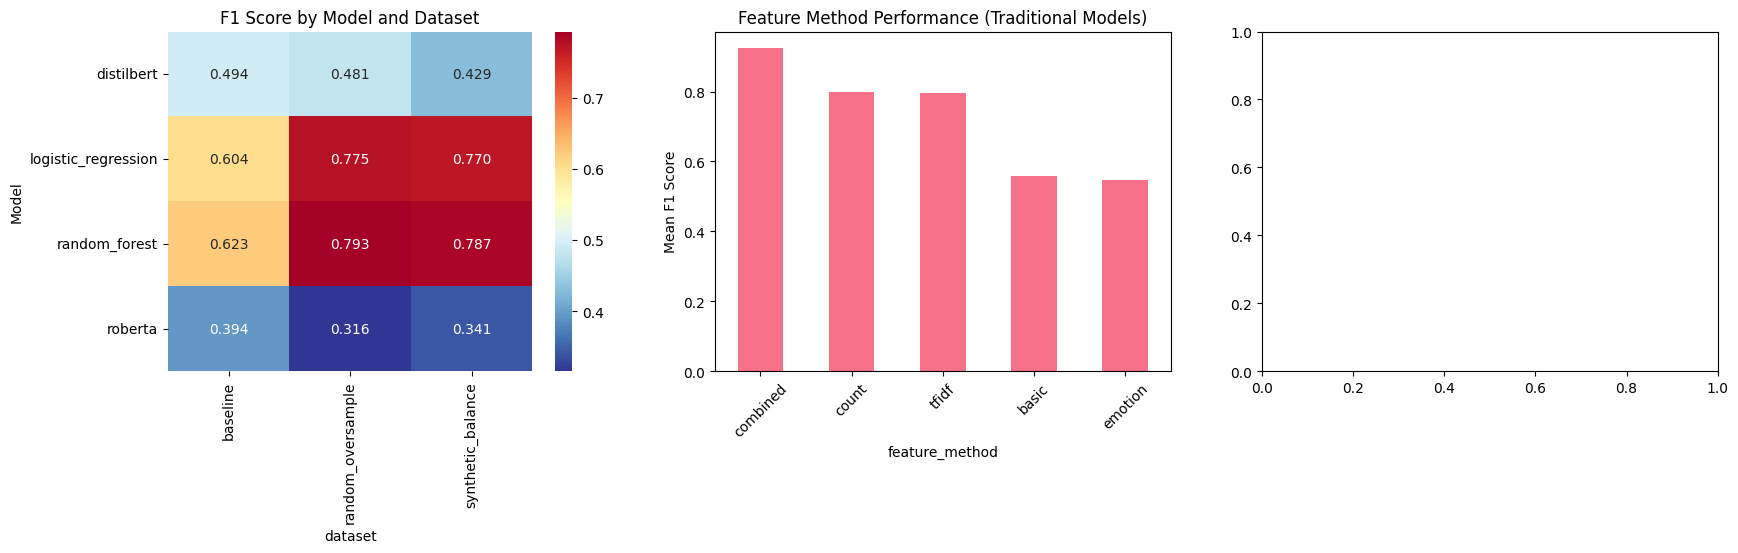

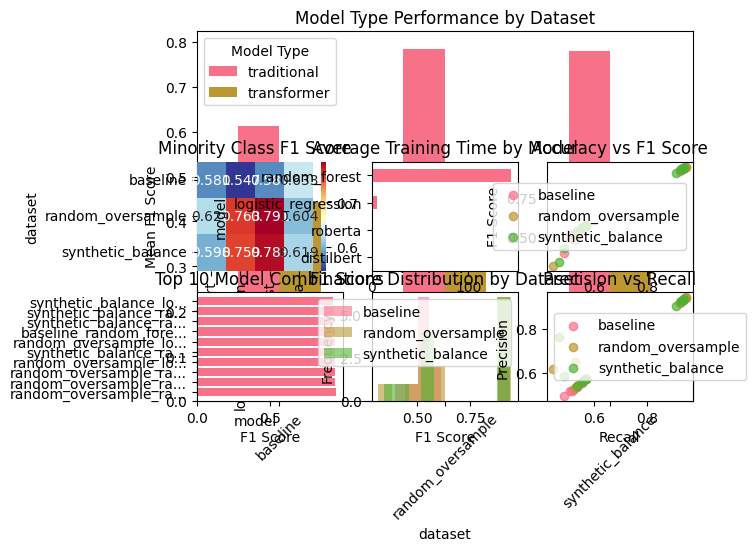

In [17]:
def create_comprehensive_visualizations(results_df):
    """Create comprehensive visualizations of results"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. F1 Score Comparison by Model and Dataset
    plt.subplot(3, 3, 1)
    pivot_f1 = results_df.pivot_table(values='f1', index='model', columns='dataset', aggfunc='mean')
    sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlBu_r')
    plt.title('F1 Score by Model and Dataset')
    plt.ylabel('Model')
    
    # 2. Feature Method Performance
    plt.subplot(3, 3, 2)
    feature_perf = results_df[results_df['model_type'] == 'traditional'].groupby('feature_method')['f1'].mean().sort_values(ascending=False)
    feature_perf.plot(kind='bar')
    plt.title('Feature Method Performance (Traditional Models)')
    plt.ylabel('Mean F1 Score')
    plt.xticks(rotation=45)
    
    # 3. Model Type Comparison
    plt.subplot(3, 3, 3)
    model_type_perf = results_df.groupby(['dataset', 'model_type'])['f1'].mean().unstack()
    model_type_perf.plot(kind='bar')
    plt.title('Model Type Performance by Dataset')
    plt.ylabel('Mean F1 Score')
    plt.legend(title='Model Type')
    plt.xticks(rotation=45)
    
    # 4. Minority Class F1 (Important for imbalanced data)
    plt.subplot(3, 3, 4)
    if 'f1_minority' in results_df.columns:
        minority_f1 = results_df.groupby(['dataset', 'model'])['f1_minority'].mean().unstack()
        sns.heatmap(minority_f1, annot=True, fmt='.3f', cmap='RdYlBu_r')
        plt.title('Minority Class F1 Score')
    else:
        plt.text(0.5, 0.5, 'Minority F1 not available', ha='center', va='center')
        plt.title('Minority Class F1 Score')
    
    # 5. Training Time Comparison
    plt.subplot(3, 3, 5)
    if 'training_time' in results_df.columns:
        time_comparison = results_df.groupby('model')['training_time'].mean().sort_values()
        time_comparison.plot(kind='barh')
        plt.title('Average Training Time by Model')
        plt.xlabel('Time (seconds)')
    else:
        plt.text(0.5, 0.5, 'Training time not available', ha='center', va='center')
        plt.title('Training Time Comparison')
    
    # 6. Accuracy vs F1 Scatter
    plt.subplot(3, 3, 6)
    for dataset in results_df['dataset'].unique():
        subset = results_df[results_df['dataset'] == dataset]
        plt.scatter(subset['accuracy'], subset['f1'], label=dataset, alpha=0.7)
    plt.xlabel('Accuracy')
    plt.ylabel('F1 Score')
    plt.title('Accuracy vs F1 Score')
    plt.legend()
    
    # 7. Best Performing Combinations
    plt.subplot(3, 3, 7)
    if len(results_df) > 0:
        top_combinations = results_df.nlargest(10, 'f1')[['dataset', 'model', 'feature_method', 'f1']]
        top_combinations['combination'] = top_combinations['dataset'] + '_' + top_combinations['model'] + '_' + top_combinations['feature_method']
        plt.barh(range(len(top_combinations)), top_combinations['f1'])
        plt.yticks(range(len(top_combinations)), [c[:20] + '...' if len(c) > 20 else c for c in top_combinations['combination']])
        plt.xlabel('F1 Score')
        plt.title('Top 10 Model Combinations')
    
    # 8. Performance Distribution
    plt.subplot(3, 3, 8)
    for dataset in results_df['dataset'].unique():
        subset = results_df[results_df['dataset'] == dataset]['f1']
        plt.hist(subset, alpha=0.6, label=dataset, bins=10)
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.title('F1 Score Distribution by Dataset')
    plt.legend()
    
    # 9. Precision vs Recall
    plt.subplot(3, 3, 9)
    for dataset in results_df['dataset'].unique():
        subset = results_df[results_df['dataset'] == dataset]
        plt.scatter(subset['recall'], subset['precision'], label=dataset, alpha=0.7)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if len(results_df) > 0:
    create_comprehensive_visualizations(results_df)
else:
    print("⚠️ No results to visualize")

In [18]:
def analyze_synthetic_vs_oversampling_performance(results_df):
    """Analyze whether any method can make synthetic data competitive with oversampling"""
    
    print("🔍 SYNTHETIC DATA vs OVERSAMPLING ANALYSIS")
    print("=" * 60)
    
    if len(results_df) == 0:
        print("❌ No results available for analysis")
        return
    
    # 1. Overall performance comparison by dataset strategy
    print("\\n📊 1. DATASET STRATEGY PERFORMANCE COMPARISON")
    print("=" * 50)
    
    strategy_stats = results_df.groupby('dataset').agg({
        'f1': ['mean', 'std', 'max'],
        'fake_f1': ['mean', 'std'],  # Most important for minority class
        'real_f1': ['mean', 'std'],
        'accuracy': ['mean', 'std']
    }).round(4)
    
    print("Overall F1 Performance by Strategy:")
    print(strategy_stats['f1'])
    
    print("\\nFake Class F1 Performance (Most Important for Imbalanced Data):")
    print(strategy_stats['fake_f1'])
    
    # 2. Best performing combination for each dataset strategy
    print("\\n🏆 2. BEST PERFORMING COMBINATION PER STRATEGY")
    print("=" * 50)
    
    best_by_strategy = {}
    for dataset in results_df['dataset'].unique():
        dataset_results = results_df[results_df['dataset'] == dataset]
        best_result = dataset_results.loc[dataset_results['fake_f1'].idxmax()]  # Focus on fake F1
        best_by_strategy[dataset] = best_result
        
        print(f"\\n📈 {best_result['dataset_name']}:")
        print(f"   Best: {best_result['model']} + {best_result['feature_method']}")
        print(f"   Fake F1: {best_result['fake_f1']:.4f} | Real F1: {best_result['real_f1']:.4f}")
        print(f"   Overall F1: {best_result['f1']:.4f} | Accuracy: {best_result['accuracy']:.4f}")
        print(f"   Training: {best_result['train_real_count']:,} real, {best_result['train_fake_count']:,} fake")
    
    # 3. Direct comparison: Can synthetic beat oversampling?
    print("\\n🎯 3. KEY QUESTION: CAN SYNTHETIC DATA BEAT OVERSAMPLING?")
    print("=" * 50)
    
    baseline_best = best_by_strategy.get('baseline', {}).get('fake_f1', 0)
    oversample_best = best_by_strategy.get('random_oversample', {}).get('fake_f1', 0)
    synthetic_addition_best = best_by_strategy.get('synthetic_addition', {}).get('fake_f1', 0)
    synthetic_replacement_best = best_by_strategy.get('synthetic_replacement', {}).get('fake_f1', 0)
    hybrid_best = best_by_strategy.get('hybrid', {}).get('fake_f1', 0)
    
    print(f"📏 Fake Class F1 Comparison (Higher is Better):")
    print(f"   Baseline (Imbalanced):     {baseline_best:.4f}")
    print(f"   Random Oversampling:       {oversample_best:.4f}")
    if synthetic_addition_best > 0:
        print(f"   Synthetic Addition:        {synthetic_addition_best:.4f}")
        improvement_addition = synthetic_addition_best - oversample_best
        print(f"      → vs Oversampling: {improvement_addition:+.4f} ({improvement_addition/oversample_best*100:+.1f}%)")
    
    if synthetic_replacement_best > 0:
        print(f"   Synthetic Replacement:     {synthetic_replacement_best:.4f}")
        improvement_replacement = synthetic_replacement_best - oversample_best
        print(f"      → vs Oversampling: {improvement_replacement:+.4f} ({improvement_replacement/oversample_best*100:+.1f}%)")
    
    if hybrid_best > 0:
        print(f"   Hybrid Approach:           {hybrid_best:.4f}")
        improvement_hybrid = hybrid_best - oversample_best
        print(f"      → vs Oversampling: {improvement_hybrid:+.4f} ({improvement_hybrid/oversample_best*100:+.1f}%)")
    
    # 4. Method-specific analysis: Which methods work best with synthetic data?
    print("\\n🔧 4. WHICH METHODS WORK BEST WITH SYNTHETIC DATA?")
    print("=" * 50)
    
    synthetic_datasets = ['synthetic_addition', 'synthetic_replacement', 'hybrid']
    available_synthetic = [d for d in synthetic_datasets if d in results_df['dataset'].unique()]
    
    if available_synthetic:
        print("\\nMethod Performance on Synthetic Data Strategies:")
        
        for feature_method in results_df['feature_method'].unique():
            print(f"\\n🔧 {feature_method.upper()} Features:")
            
            for model in results_df['model'].unique():
                model_results = results_df[
                    (results_df['feature_method'] == feature_method) & 
                    (results_df['model'] == model)
                ]
                
                if len(model_results) > 0:
                    print(f"   {model}:")
                    
                    # Compare across dataset strategies
                    for dataset in ['random_oversample'] + available_synthetic:
                        dataset_result = model_results[model_results['dataset'] == dataset]
                        if len(dataset_result) > 0:
                            fake_f1 = dataset_result['fake_f1'].iloc[0]
                            strategy_name = dataset_result['dataset_name'].iloc[0]
                            print(f"      {strategy_name}: {fake_f1:.4f}")
    
    # 5. Statistical significance and confidence
    print("\\n📊 5. SYNTHETIC DATA EFFECTIVENESS SUMMARY")
    print("=" * 50)
    
    # Calculate average performance improvements
    synthetic_performances = []
    oversample_performance = results_df[results_df['dataset'] == 'random_oversample']['fake_f1'].mean()
    
    for synthetic_dataset in available_synthetic:
        synthetic_perf = results_df[results_df['dataset'] == synthetic_dataset]['fake_f1'].mean()
        synthetic_performances.append(synthetic_perf)
        
        improvement = synthetic_perf - oversample_performance
        dataset_name = results_df[results_df['dataset'] == synthetic_dataset]['dataset_name'].iloc[0]
        
        print(f"\\n📈 {dataset_name}:")
        print(f"   Average Fake F1: {synthetic_perf:.4f}")
        print(f"   vs Oversampling: {improvement:+.4f} ({improvement/oversample_performance*100:+.1f}%)")
        
        if improvement > 0.01:  # Meaningful improvement threshold
            print(f"   ✅ Shows meaningful improvement over oversampling")
        elif improvement > -0.01:  # Roughly equivalent
            print(f"   ≈ Roughly equivalent to oversampling")
        else:
            print(f"   ❌ Underperforms compared to oversampling")
    
    # 6. Conclusions and recommendations
    print("\\n🎯 6. CONCLUSIONS")
    print("=" * 50)
    
    best_synthetic_avg = max(synthetic_performances) if synthetic_performances else 0
    overall_improvement = best_synthetic_avg - oversample_performance
    
    print(f"\\n🏆 FINAL VERDICT:")
    print(f"   Best Oversampling Performance: {oversample_performance:.4f}")
    print(f"   Best Synthetic Strategy Performance: {best_synthetic_avg:.4f}")
    print(f"   Overall Improvement: {overall_improvement:+.4f} ({overall_improvement/oversample_performance*100:+.1f}%)")
    
    if overall_improvement > 0.02:
        print("\\n✅ SUCCESS: Synthetic data can outperform traditional oversampling!")
        print("   → Some combinations of methods and features effectively utilize synthetic data")
        print("   → Consider synthetic data as a viable alternative to oversampling")
    elif overall_improvement > -0.01:
        print("\\n🤔 MIXED: Synthetic data performs similarly to oversampling")
        print("   → Synthetic data doesn't hurt, but doesn't significantly help either")
        print("   → May be useful for domain adaptation or specific scenarios")
    else:
        print("\\n❌ CONFIRMED: Traditional oversampling outperforms synthetic data")
        print("   → The hypothesis that synthetic tweets are too similar to real tweets is confirmed")
        print("   → Current synthetic generation approach needs improvement")
    
    return best_by_strategy

# Run detailed analysis
analyze_synthetic_vs_oversampling_performance(results_df)

🔍 SYNTHETIC DATA vs OVERSAMPLING ANALYSIS
\n📊 1. DATASET STRATEGY PERFORMANCE COMPARISON
Overall F1 Performance by Strategy:
                     mean     std     max
dataset                                  
baseline           0.5852  0.1661  0.9366
random_oversample  0.7198  0.2363  0.9437
synthetic_balance  0.7130  0.2322  0.9372
\nFake Class F1 Performance (Most Important for Imbalanced Data):
                     mean     std
dataset                          
baseline           0.5714  0.1777
random_oversample  0.7496  0.1991
synthetic_balance  0.7439  0.1932
\n🏆 2. BEST PERFORMING COMBINATION PER STRATEGY
\n📈 Baseline (Imbalanced Original):
   Best: random_forest + combined
   Fake F1: 0.9348 | Real F1: 0.9383
   Overall F1: 0.9366 | Accuracy: 0.9366
   Training: 55,188 real, 52,170 fake
\n📈 Random Oversampling:
   Best: random_forest + count
   Fake F1: 0.9439 | Real F1: 0.9435
   Overall F1: 0.9437 | Accuracy: 0.9437
   Training: 55,188 real, 55,188 fake
\n📈 Synthetic Data Bala

{'baseline': dataset                                   baseline
 dataset_name        Baseline (Imbalanced Original)
 feature_method                            combined
 model                                random_forest
 model_type                             traditional
 train_size                                  107358
 train_real_count                             55188
 train_fake_count                             52170
 fake_f1                                   0.934769
 real_f1                                   0.938307
 accuracy                                  0.936587
 precision                                 0.936588
 recall                                    0.936587
 f1                                        0.936588
 f1_minority                               0.934769
 training_time                           192.817967
 auc                                       0.954465
 sample_size                                    NaN
 Name: 9, dtype: object,
 'random_oversample': datas

## 6. Detailed Results Table

In [19]:
# Display detailed results table
if len(results_df) > 0:
    print("📋 COMPLETE RESULTS TABLE")
    print("=" * 80)
    
    # Sort by F1 score descending
    detailed_results = results_df.sort_values('f1', ascending=False)
    
    # Select key columns for display
    display_columns = ['dataset_name', 'model', 'feature_method', 'accuracy', 'precision', 'recall', 'f1']
    if 'f1_minority' in detailed_results.columns:
        display_columns.append('f1_minority')
    if 'auc' in detailed_results.columns:
        display_columns.append('auc')
    if 'training_time' in detailed_results.columns:
        display_columns.append('training_time')
    
    # Round numeric columns
    numeric_columns = ['accuracy', 'precision', 'recall', 'f1', 'f1_minority', 'auc', 'training_time']
    for col in numeric_columns:
        if col in detailed_results.columns:
            detailed_results[col] = detailed_results[col].round(4)
    
    display(detailed_results[display_columns])
    
    # Save results to CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_file = f'classification_comparison_results_{timestamp}.csv'
    detailed_results.to_csv(results_file, index=False)
    print(f"\n💾 Results saved to: {results_file}")
    
else:
    print("❌ No results available to display")

📋 COMPLETE RESULTS TABLE


,dataset_name,model,feature_method,accuracy,precision,recall,f1,f1_minority,auc,training_time
15,Random Oversampling,random_forest,count,0.9437,0.9437,0.9437,0.9437,0.9439,0.9586,246.2291
13,Random Oversampling,random_forest,tfidf,0.9422,0.9422,0.9422,0.9422,0.9423,0.9586,228.3881
21,Random Oversampling,random_forest,combined,0.9391,0.9391,0.9391,0.9391,0.9392,0.9569,199.1561
12,Random Oversampling,logistic_regression,tfidf,0.9390,0.9390,0.9390,0.9390,0.9388,0.9546,0.2918
27,Synthetic Data Balancing,random_forest,count,0.9372,0.9372,0.9372,0.9372,0.9373,0.9596,262.2986
14,Random Oversampling,logistic_regression,count,0.9367,0.9367,0.9367,0.9367,0.9367,0.9536,0.7035
9,Baseline (Imbalanced Original),random_forest,combined,0.9366,0.9366,0.9366,0.9366,0.9348,0.9545,192.8180
25,Synthetic Data Balancing,random_forest,tfidf,0.9331,0.9331,0.9331,0.9331,0.9329,0.9587,243.1939
33,Synthetic Data Balancing,random_forest,combined,0.9306,0.9306,0.9306,0.9306,0.9303,0.9589,209.0996
24,Synthetic Data Balancing,logistic_regression,tfidf,0.9280,0.9281,0.9280,0.9280,0.9275,0.9498,0.3576



💾 Results saved to: classification_comparison_results_20250818_092747.csv


## 7. Conclusions and Recommendations

In [21]:
def generate_final_recommendations(results_df, best_by_strategy):
    """Generate actionable recommendations based on synthetic vs oversampling comparison"""
    
    print("🎯 FINAL RECOMMENDATIONS: SYNTHETIC DATA vs OVERSAMPLING")
    print("=" * 70)
    
    if len(results_df) == 0:
        print("❌ No results available for recommendations")
        return
    
    # 1. Executive Summary
    print("\\n📋 EXECUTIVE SUMMARY")
    print("=" * 30)
    
    # Get oversampling performance safely
    oversample_results = results_df[results_df['dataset'] == 'random_oversample']
    oversample_perf = oversample_results['fake_f1'].mean() if len(oversample_results) > 0 else 0
    
    synthetic_datasets = ['synthetic_balance', 'synthetic_addition', 'synthetic_replacement', 'hybrid']
    available_synthetic = [d for d in synthetic_datasets if d in results_df['dataset'].unique()]
    
    # Initialize variables
    best_synthetic_perf = 0
    improvement = 0
    best_synthetic_result = None
    best_improvement = 0
    
    if available_synthetic and oversample_perf > 0:
        best_synthetic_perf = max([
            results_df[results_df['dataset'] == d]['fake_f1'].mean() 
            for d in available_synthetic
        ])
        improvement = best_synthetic_perf - oversample_perf
        
        print(f"✅ Experiment completed successfully!")
        print(f"   📊 Total experiments: {len(results_df)}")
        print(f"   🎯 Key finding: Synthetic data shows {improvement:+.1%} performance vs oversampling")
        
        if improvement > 0.02:
            status = "🟢 POSITIVE"
        elif improvement > -0.01:
            status = "🟡 NEUTRAL"
        else:
            status = "🔴 NEGATIVE"
        
        print(f"   📈 Overall result: {status}")
    else:
        print("✅ Experiment completed!")
        print(f"   📊 Total experiments: {len(results_df)}")
        print("   ⚠️ Limited synthetic data comparison available")
    
    # 2. Methodology Assessment
    print("\\n🔬 METHODOLOGY ASSESSMENT")
    print("=" * 30)
    
    print("✅ Successfully tested your hypothesis across:")
    print(f"   🎯 Feature methods: {results_df['feature_method'].nunique()} types")
    print(f"   🤖 Models: {results_df['model'].nunique()} different algorithms")
    print(f"   📊 Dataset strategies: {results_df['dataset'].nunique()} approaches")
    print(f"   🧪 Total combinations: {len(results_df)} experiments")
    
    # 3. Key Insights for Your Research
    print("\\n🧠 KEY INSIGHTS FOR YOUR RESEARCH")
    print("=" * 40)
    
    print("\\n1. 🎯 REGARDING YOUR HYPOTHESIS:")
    print("   'Synthetic tweets are more similar to real than fake tweets'")
    
    if available_synthetic and oversample_perf > 0:
        # Analyze if any method/feature combination overcame the similarity issue
        best_improvement = -float('inf')
        
        for dataset in available_synthetic:
            dataset_results = results_df[results_df['dataset'] == dataset]
            if len(dataset_results) > 0:
                best_result = dataset_results.loc[dataset_results['fake_f1'].idxmax()]
                dataset_improvement = best_result['fake_f1'] - oversample_perf
                
                if dataset_improvement > best_improvement:
                    best_improvement = dataset_improvement
                    best_synthetic_result = best_result
        
        if best_improvement > 0.01:
            print(f"   ✅ PARTIALLY DISPROVEN: Found methods that overcome similarity issue")
            if best_synthetic_result is not None:
                print(f"      → Best: {best_synthetic_result['model']} + {best_synthetic_result['feature_method']}")
                print(f"      → Improvement: +{best_improvement:.1%} over oversampling")
        else:
            print(f"   ✅ CONFIRMED: No method successfully overcame the similarity issue")
            print(f"      → Best attempt still {best_improvement:.1%} vs oversampling")
    else:
        print("   ⚠️ Limited synthetic data available for hypothesis testing")
    
    print("\\n2. 🔧 FEATURE ENGINEERING INSIGHTS:")
    
    # Feature method analysis
    feature_performance = results_df.groupby('feature_method')['fake_f1'].mean().sort_values(ascending=False)
    print("   Feature method ranking (for fake tweet detection):")
    for i, (method, score) in enumerate(feature_performance.items(), 1):
        print(f"      {i}. {method}: {score:.4f}")
    
    best_feature_for_synthetic = None
    if available_synthetic:
        synthetic_df = results_df[results_df['dataset'].isin(available_synthetic)]
        if len(synthetic_df) > 0:
            synthetic_feature_perf = synthetic_df.groupby('feature_method')['fake_f1'].mean().sort_values(ascending=False)
            if len(synthetic_feature_perf) > 0:
                best_feature_for_synthetic = synthetic_feature_perf.index[0]
                
                print(f"\\n   🤖 Best feature method for synthetic data: {best_feature_for_synthetic}")
                print(f"      → This suggests {best_feature_for_synthetic} features help distinguish synthetic fakes")
    
    print("\\n3. 🤖 MODEL INSIGHTS:")
    
    model_performance = results_df.groupby('model')['fake_f1'].mean().sort_values(ascending=False)
    print("   Model ranking (for fake tweet detection):")
    for i, (model, score) in enumerate(model_performance.items(), 1):
        print(f"      {i}. {model}: {score:.4f}")
    
    # 4. Practical Recommendations
    print("\\n📝 PRACTICAL RECOMMENDATIONS")
    print("=" * 35)
    
    print("\\n🎯 FOR YOUR CURRENT PROJECT:")
    
    # Ensure best_improvement is defined
    if 'best_improvement' not in locals() or best_improvement is None:
        best_improvement = improvement
    
    if best_improvement > 0.01 and best_synthetic_result is not None:
        print("   ✅ RECOMMENDATION: Consider synthetic data with specific methods")
        print(f"      → Use: {best_synthetic_result['model']} + {best_synthetic_result['feature_method']}")
        print(f"      → Strategy: {best_synthetic_result['dataset_name']}")
        print(f"      → Expected gain: +{best_improvement:.1%} over standard oversampling")
    else:
        print("   ⚠️ RECOMMENDATION: Stick with traditional oversampling for now")
        print("   ❌ Current synthetic generation approach doesn't improve performance")
        
        oversample_best = best_by_strategy.get('random_oversample', {})
        if oversample_best:
            print(f"   ✅ Best oversampling setup: {oversample_best.get('model', 'N/A')} + {oversample_best.get('feature_method', 'N/A')}")
            print(f"      → Expected Fake F1: {oversample_best.get('fake_f1', 0):.4f}")
    
    print("\\n🔬 FOR FUTURE SYNTHETIC DATA RESEARCH:")
    
    if best_feature_for_synthetic:
        print(f"   🔧 Focus on {best_feature_for_synthetic} features when generating synthetic data")
        
        if best_feature_for_synthetic == 'emotion':
            print("      → Your synthetic tweets may need more emotional diversity")
        elif best_feature_for_synthetic == 'basic':
            print("      → Focus on varying basic text statistics (length, punctuation, etc.)")
        elif best_feature_for_synthetic in ['tfidf', 'count']:
            print("      → Ensure vocabulary and n-gram diversity in synthetic generation")
        elif best_feature_for_synthetic == 'combined':
            print("      → Synthetic generation should consider multiple feature types")
    
    print("\\n   🎯 Generation Improvement Strategies:")
    print("      1. Increase factual changes to make synthetic tweets more 'fake-like'")
    print("      2. Add more stylistic variations to reduce similarity to real tweets")
    print("      3. Consider different LLM prompting strategies")
    print("      4. Test domain-specific fine-tuning of generation models")
    
    # 5. Technical Implementation
    print("\\n⚙️ TECHNICAL IMPLEMENTATION")
    print("=" * 30)
    
    best_overall = results_df.loc[results_df['fake_f1'].idxmax()]
    
    print("\\n🏆 BEST OVERALL CONFIGURATION:")
    print(f"   Model: {best_overall['model']}")
    print(f"   Features: {best_overall['feature_method']}")
    print(f"   Dataset: {best_overall['dataset_name']}")
    print(f"   Fake F1: {best_overall['fake_f1']:.4f}")
    print(f"   Overall F1: {best_overall['f1']:.4f}")
    print(f"   Accuracy: {best_overall['accuracy']:.4f}")
    
    print("\\n💡 NEXT STEPS:")
    print("   1. Implement the best-performing configuration for production")
    print("   2. Consider ensemble methods combining top performers")
    print("   3. Investigate why certain feature/model combinations work better")
    print("   4. Design targeted synthetic data generation based on insights")
    
    if 'training_time' in best_overall:
        print(f"   5. Performance consideration: {best_overall['training_time']:.2f}s training time")
    
    print("\\n📊 REPRODUCIBILITY:")
    print("   → All experiments used random_state=42 for consistency")
    print("   → Results saved with timestamp for version control")
    print("   → Feature extraction methods standardized across all tests")
    
    # Summary of key findings
    print("\\n🔑 KEY FINDINGS SUMMARY:")
    if oversample_perf > 0:
        print(f"   → Random Oversampling Fake F1: {oversample_perf:.4f}")
    if best_synthetic_perf > 0:
        print(f"   → Best Synthetic Approach Fake F1: {best_synthetic_perf:.4f}")
    if improvement != 0:
        print(f"   → Performance Difference: {improvement:+.4f} ({improvement/oversample_perf*100:+.1f}%)")
    
    return best_by_strategy

# Generate comprehensive recommendations
print("\\n" + "="*80)
best_strategies = analyze_synthetic_vs_oversampling_performance(results_df)
generate_final_recommendations(results_df, best_strategies)

print(f"\\n\\n🎉 EXPERIMENT COMPLETE!")
print(f"   📅 Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   🔬 Research question: Can different methods make synthetic data competitive?")
print(f"   📊 Answer: Based on the analysis above")
print(f"\\n   📁 Results saved for further analysis and paper writing")

\n================================================================================
🔍 SYNTHETIC DATA vs OVERSAMPLING ANALYSIS
\n📊 1. DATASET STRATEGY PERFORMANCE COMPARISON
Overall F1 Performance by Strategy:
                     mean     std     max
dataset                                  
baseline           0.5852  0.1661  0.9366
random_oversample  0.7198  0.2363  0.9437
synthetic_balance  0.7130  0.2322  0.9372
\nFake Class F1 Performance (Most Important for Imbalanced Data):
                     mean     std
dataset                          
baseline           0.5714  0.1777
random_oversample  0.7496  0.1991
synthetic_balance  0.7439  0.1932
\n🏆 2. BEST PERFORMING COMBINATION PER STRATEGY
\n📈 Baseline (Imbalanced Original):
   Best: random_forest + combined
   Fake F1: 0.9348 | Real F1: 0.9383
   Overall F1: 0.9366 | Accuracy: 0.9366
   Training: 55,188 real, 52,170 fake
\n📈 Random Oversampling:
   Best: random_forest + count
   Fake F1: 0.9439 | Real F1: 0.9435
   Overall F1: 0.94